# Laboratorium 5 - Konwolucyjne sieci neuronowe

## Przykład 1 (5.2)

In [17]:
import numpy as np

input = np.array([[8.5, 0.65, 1.2],
                  [9.5, 0.8, 1.3],
                  [9.9, 0.8, 0.5],
                  [9.0, 0.9,1.0]])

expected_output = np.array([[0],
                            [1]])

alpha = 0.01
kernels = np.array([[0.1, 0.2, -0.1, -0.1, 0.1, 0.9, 0.1, 0.4, 0.1],
                    [0.3, 1.1, -0.3, 0.1, 0.2, 0.0, 0.0, 1.3, 0.1]])
kernel_1_weights = np.array([0.1, 0.2, -0.1, -0.1, 0.1, 0.9, 0.1, 0.4, 0.1])
kernel_2_weights = np.array([0.3, 1.1, -0.3, 0.1, 0.2, 0.0, 1.3, 0.1])
wy = np.array([[0.1, -0.2, 0.1, 0.3],
               [0.2, 0.1, 0.5,  -0.3]])

size_of_filter = len(kernel_1_weights)
number_of_filters = 2
image_sections = np.zeros((number_of_filters,size_of_filter))
image_sections[0] = input[:3,:3].T.flatten()
image_sections[1] = input[1:4,:3].T.flatten()

kernel_layer = np.dot(image_sections, kernels.T)

output = np.dot(wy,kernel_layer.flatten().reshape(-1,1))

#liczenie błędu
output_delta = (2/2)*(output - expected_output)

kernel_delta = np.dot(wy.T, output_delta)
kernel_delta_reshaped = kernel_delta.reshape(2,2)

#skalowanie błędu
output_delta_weight = np.dot(output_delta, kernel_layer.flatten().reshape(-1,1).T)
kernel_delta_weight = np.dot(kernel_delta.reshape(2,2).T, image_sections)

#aktualizacja wag
wy = wy - alpha*output_delta_weight
kernels = kernels - alpha*kernel_delta_weight
print(kernels)



[[ 0.13996975  0.24192205 -0.06135895 -0.09666173  0.1034012   0.9037844
   0.105485    0.40246135  0.10404175]
 [ 0.25591175  1.05716865 -0.33281085  0.09596833  0.1966956  -0.0042023
  -0.0058545   1.30181355  0.09344525]]


## Zadanie 1
Splot

In [18]:
def conv(img, filter, step=1, padding=0):
    img_with_padding = np.zeros((img.shape[0]+2*padding,img.shape[1]+2*padding))
    img_with_padding[padding:padding+img.shape[0],padding:padding+img.shape[1]] = img
    res = np.zeros((len(img_with_padding)-filter.shape[0]+1,len(img_with_padding.T)-filter.shape[1]+1))
    section = np.zeros(filter.shape)
    for i in range(0,len(img_with_padding)-filter.shape[0]+1,step):
        for j in range(0,len(img_with_padding.T)-filter.shape[1]+1,step):
            section = img_with_padding[i*step:i*step+filter.shape[0], j*step:j*step+filter.shape[1]]
            res[i,j] = np.sum(section * filter)
    return res


image = np.array([[1,1,1,0,0],
                  [0,1,1,1,0],
                  [0,0,1,1,1],
                  [0,0,1,1,0],
                  [0,1,1,0,0]])
filter = np.array([[1,0,1],
                   [0,1,0],
                   [1,0,1]])


res = conv(image,filter,1,0)
print(res)

[[4. 3. 4.]
 [2. 4. 3.]
 [2. 3. 4.]]


## Zadanie 2
Sieć konwolucyjna

In [ ]:
import numpy as np
from math import sqrt

class neural_network:
    def __init__(self, number_of_input):
        self.number_of_input = number_of_input
        self.layers = []   
        self.activation_functions = []
        self.output_size = 0

#dodawanie warstw
    def add_layer(self, n, weight_min_value=0, weight_max_value=1, activation_function=None):
        new_matrix = np.random.uniform(weight_min_value,weight_max_value,(n,self.output_size))

        self.layers.append(new_matrix)
        self.activation_functions.append(activation_function)

        self.output_size = n
            
    def load_weights(self, filename, activation_function=None):
        weights = np.loadtxt(filename)
        self.layers.append(weights)
        self.activation_functions.append(activation_function)

    def input_weights(self, weights, activation_function=None):
        self.layers.append(weights)
        self.activation_functions.append(activation_function)

    def add_conv_layer(self, number_of_filters, size_of_filter,weight_min_value=0, weight_max_value=1, activation_function=None, pool = False):
        cols = size_of_filter[0]*size_of_filter[1]
        
        new_matrix = np.random.uniform(weight_min_value,weight_max_value,(number_of_filters, cols))

        self.layers.append(new_matrix)
        self.activation_functions.append(activation_function)

        #ustalamy jak duży będzie output
        number_of_sections = 28 - size_of_filter[0] + 1 #28, ponieważ taki będzie bok obrazu w mnist
        number_of_sections *= 28- size_of_filter[1] + 1
        self.output_size = number_of_sections * number_of_filters
        if pool:
            self.output_size = int(self.output_size/4)

    

    def predict(self, input):
        res = input
        for weight_matrix, activation_function in zip(self.layers, self.activation_functions):
            res = np.dot(weight_matrix, res)
            if activation_function is not None:
                res = activation_function(res)
        return res
    
    def predict_with_conv2(self, input):
        sections = self.make_sections(input, self.layers[0].shape[1])

        #wynik z warstwy konwolucyjnej
        kernel_output = np.dot(sections,self.layers[0].T)
        kernel_output_flatten = kernel_output.flatten().T
        #funkcja aktywacji
        kernel_output_flatten = self.activation_functions[0](kernel_output_flatten)

        #wynik sieci
        output = np.dot(self.layers[-1],kernel_output_flatten)

    
    def predict_with_conv(self, input):
        output = np.zeros((len(input)))
        for series in range(len(input)):
            sections = self.make_sections(input[series], self.layers[0].shape[1])

            #wynik z warstwy konwolucyjnej
            kernel_output = np.dot(sections,self.layers[0].T)
            kernel_output_flatten = kernel_output.flatten().T
            #funkcja aktywacji
            kernel_output_flatten = self.activation_functions[0](kernel_output_flatten)

            #wynik sieci
            res = np.dot(self.layers[-1],kernel_output_flatten)
            output[series] = np.argmax(res)

        return output

    def predict_with_conv_and_pool(self, input):
        output = np.zeros((len(input)))
        for series in range(len(input)):
            sections = self.make_sections(input[series], self.layers[0].shape[1])

            #wynik z warstwy konwolucyjnej
            kernel_output = np.dot(sections,self.layers[0].T)
            
            #funkcja aktywacji
            kernel_output = self.activation_functions[0](kernel_output)
            deriv = self.activation_functions[0](kernel_output, True)
            deriv = deriv.reshape(-1,1)

            #pooling
            x, y = kernel_output.shape
            x = int(x/2)
            y = int(y/2)
            output_pool = np.zeros((x,y))
            x=0
            max_mask = np.zeros(kernel_output.shape)

            for i in range(0, len(kernel_output), 2):
                y=0
                for j in range(0, len(kernel_output.T), 2):
                    mask = kernel_output[i:i+2,j:j+2]
                    output_pool[x,y] = np.max(mask)
                    
                    output_pool[x,y] = np.max(mask)
                    tmp_vec = np.zeros(4)
                    tmp_vec[np.argmax(mask)] = 1
                    max_mask[i:i+2, j:j+2] = tmp_vec.reshape(2,2)

                    y+=1
                x+=1
            output_pool = output_pool.flatten()
            

            #wynik sieci
            res = np.dot(self.layers[-1],output_pool)
            output[series] = np.argmax(res)

        return output


#aktualizowanie wag
    def update(self, input, goal, alpha, epochs, dropout_p = 0.5):
        np.set_printoptions(precision=6)
        for i in range(0, epochs):
            for series in range(len(input)):
                #liczenie wyniku i wyniku warstwy ukrytej
                output = self.predict(input[series])
                hidden_output = np.dot(self.layers[0], input[series])
                hidden_output = self.relu(hidden_output)

                #dropout (4.1)
                number_of_neurons = self.layers[0].shape[0]
                dropout_mask = (np.random.rand(number_of_neurons) > dropout_p).astype(float)
                hidden_output *= dropout_mask
                hidden_output /= (1 - dropout_p)


                error = np.sum((output - goal[series]) ** 2)
                if np.isinf(error) or np.isnan(error):
                    print(f"ERROR! error is {error}")
                    return
                error = error * (1 / len(self.layers[1]))

                delta_output = (2 / len(self.layers[1])) * (output - goal[series])
                delta_hidden = np.dot(delta_output, self.layers[1])

                delta_hidden = delta_hidden * self.relu_deriv(hidden_output)
                delta_output = np.outer(delta_output, hidden_output.T)
                
                delta_hidden_weight = np.outer(delta_hidden, input[series].T)
                self.layers[1] -= alpha * delta_output
                self.layers[0] -= alpha * delta_hidden_weight

    def update_mini_batch2(self, input, goal, alpha, epochs, dropout_p = 0.5, batch_size = 1):
        np.set_printoptions(precision=6)
        for i in range(0, epochs):
            for series in range(0, len(input)+1, batch_size):
                #tworzenie batchu
                batch_input = input[:, series:series+batch_size]

                #liczenie wyniku i wyniku warstwy ukrytej
                output = self.predict(batch_input)
                output = self.softmax(output)
                hidden_output = np.dot(self.layers[0], batch_input)
                hidden_output = self.activation_functions[0](hidden_output)

                #dropout
                number_of_neurons = self.layers[0].shape[0]
                dropout_mask = (np.random.rand(number_of_neurons) > dropout_p).astype(float)
                hidden_output *= dropout_mask
                hidden_output /= (1 - dropout_p)

                #liczenie błędu
                delta_output = ((2 / len(self.layers[1])) * (output - goal[:, series:series+batch_size]))/batch_size
                if np.isinf(delta_output).any() or np.isnan(delta_output).any():
                    print(f"ERROR! delta_output is {delta_output}")
                    return
                delta_hidden = np.dot(self.layers[1].T, delta_output)
                delta_hidden = delta_hidden * self.activation_functions[0](hidden_output, True)
                
                #skalowanie błędu
                delta_output_weight = np.dot(delta_output, hidden_output.T)
                delta_hidden_weight = np.dot(delta_hidden, batch_input.T)

                #aktualizacja wag
                self.layers[1] -= alpha * delta_output_weight
                self.layers[0] -= alpha * delta_hidden_weight
                
    def make_sections(self, img, filter_size):
        side_size = int(sqrt(filter_size))
        number_of_sections = img.shape[0] - side_size + 1
        number_of_sections *= img.shape[1] - side_size + 1

        res = np.zeros((number_of_sections,filter_size))
        n = 0
        for i in range(len(img)-side_size+1):
            for j in range(len(img)-side_size+1):
                res[n] = img[i:i+side_size, j:j+side_size].T.flatten()
                n+=1
        return res
    
    #zadanie 2 (5.4)
    def update_with_conv(self, input, goal, alpha, epochs):
        np.set_printoptions(threshold=np.inf)
        for i in range(0, epochs):
            total_error = 0
            for series in range(len(input)):
                #podzielenie obrazu na fragmenty
                img = input[series]
                sections = self.make_sections(img, self.layers[0].shape[1])

                #wynik z warstwy konwolucyjnej
                kernel_output = np.dot(sections,self.layers[0].T)

                #funkcja aktywacji
                kernel_output = self.activation_functions[0](kernel_output)
                deriv = self.activation_functions[0](kernel_output, True)
                deriv = deriv.reshape(-1,1)
                kernel_output_flatten = kernel_output.flatten().T

                #wynik sieci
                output = np.dot(self.layers[-1],kernel_output_flatten)
                output = output.reshape(10,1)
                output = self.softmax(output)

                #liczenie błedu
                delta_output = (2 / len(self.layers[1])) * (output - goal[series].reshape(10,1))
                if np.isinf(delta_output).any() or np.isnan(delta_output).any():
                    print(f"ERROR! delta_output is {delta_output}")
                    return
                total_error += np.sum(np.abs(delta_output))
                delta_kernel = np.dot(self.layers[1].T, delta_output)
                delta_kernel = delta_kernel*deriv


                #przekształcamy deltę w macierz
                delta_kernel_matrix = delta_kernel.reshape(kernel_output.shape[0],kernel_output.shape[1])
                
                #skalowanie delt
                delta_output = delta_output.reshape((10,1))
                delta_output_weight = np.dot(delta_output,kernel_output_flatten.reshape(1,-1))
                delta_kernel_weight = np.dot(delta_kernel_matrix.T, sections)

                #aktualizacja wag
                self.layers[-1] -= alpha*delta_output_weight
                self.layers[0] -= alpha*delta_kernel_weight
            
            print(f"Epoch nr {i + 1}    Total Error = {total_error}")

    #Zadanie 3 (5.5)
    def update_with_conv_and_pool(self, input, goal, alpha, epochs):
        np.set_printoptions(threshold=np.inf)
        for i in range(0, epochs):
            total_error = 0
            for series in range(len(input)):
                #podzielenie obrazu na fragmenty
                img = input[series]
                sections = self.make_sections(img, self.layers[0].shape[1])

                #wynik z warstwy konwolucyjnej
                kernel_output = np.dot(sections,self.layers[0].T)

                #funkcja aktywacji
                kernel_output = self.activation_functions[0](kernel_output)
                deriv = self.activation_functions[0](kernel_output, True)
                deriv = deriv.reshape(-1,1)

                #pooling
                x, y = kernel_output.shape
                x = int(x/2)
                y = int(y/2)
                output_pool = np.zeros((x,y))
                x=0
                max_mask = np.zeros(kernel_output.shape)

                for i in range(0, len(kernel_output), 2):
                    y=0
                    for j in range(0, len(kernel_output.T), 2):
                        mask = kernel_output[i:i+2,j:j+2]
                        output_pool[x,y] = np.max(mask)
                        
                        tmp_vec = np.zeros(4)
                        tmp_vec[np.argmax(mask)] = 1
                        max_mask[i:i+2, j:j+2] = tmp_vec.reshape(2,2)
    
                        y+=1
                    x+=1
                output_pool = output_pool.flatten()
            
                #wynik sieci
                output = np.dot(self.layers[-1],output_pool)
                output = output.reshape(10,1)
                output = self.softmax(output)
                
                #liczenie błedu
                delta_output = (2 / len(self.layers[1])) * (output - goal[series].reshape(10,1))
                if np.isinf(delta_output).any() or np.isnan(delta_output).any():
                    print(f"ERROR! delta_output is {delta_output}")
                    return
                total_error += np.sum(np.abs(delta_output))
                delta_kernel = np.dot(self.layers[1].T, delta_output)
                delta_kernel = np.repeat(delta_kernel,4,axis=1)
                delta_kernel = delta_kernel.reshape(676,16)
                delta_kernel = delta_kernel*max_mask

                #przekształcamy deltę w macierz
                delta_kernel_matrix = delta_kernel.reshape(kernel_output.shape[0],kernel_output.shape[1])
                
                #skalowanie delt
                delta_output = delta_output.reshape((10,1))
                delta_output_weight = np.dot(delta_output,output_pool.reshape(1,-1))
                delta_kernel_weight = np.dot(delta_kernel_matrix.T, sections)
                
                #aktualizacja wag
                self.layers[-1] -= alpha*delta_output_weight
                self.layers[0] -= alpha*delta_kernel_weight
            
            print(f"Epoch nr {i + 1}    Total Error = {total_error}")

#funkcje aktywacji
    def relu(self, x, deriv = False):
        if deriv:
            np.array(x)
            return np.where(x > 0, 1, 0)
        else: 
            return np.maximum(0, x)

    def sigmoid(self, input, deriv = False):
        if deriv:
            return input * (1 - input)
        else:
            return 1/(1+ np.exp(-input))
    
    def tanh(self, x, deriv=False):
        if deriv:
            return 1 - np.tanh(x)**2
        else:
            return np.tanh(x)

    def softmax(self, x):
        res = np.zeros(x.shape)
        for series in range(len(x.T)):
            res[:,series] = np.exp(x[:,series])/np.sum(np.exp(x[:,series]))
        return res


In [4]:
def evaluate_model(network, test_inputs, test_outputs):
    predictions = network.predict_with_conv(test_inputs)
    
    accuracy = np.mean(predictions == test_outputs) * 100
    return accuracy


In [5]:
import tensorflow as tf

def label_to_matrix(labels):
    outputs = np.zeros((len(labels),10))
    for i in range(len(labels)):
        outputs[i,labels[i]] = 1

    return outputs

mnist = tf.keras.datasets.mnist
(img_train, y_train), (img_test, y_test) = mnist.load_data()


img_train = img_train/255.0
img_test = img_test/255.0


#spłaszczenie obrazów
img_train_flat = img_train.reshape(60000, 784)


labal_train = label_to_matrix(y_train)

In [6]:
network = neural_network(784)

network.add_conv_layer(16, (3,3), -0.01, 0.01, network.relu)
network.add_layer(10,-0.1,0.1)

np.set_printoptions(threshold=np.inf)
network.update_with_conv(img_train[:1000],labal_train[:1000],alpha=0.1,epochs=50)



Epoch nr 1    Total Error = 159.01345847142392
Epoch nr 2    Total Error = 75.5133467782157
Epoch nr 3    Total Error = 50.51156684996522
Epoch nr 4    Total Error = 30.68867725470807
Epoch nr 5    Total Error = 14.473641875534543
Epoch nr 6    Total Error = 10.490652412878937
Epoch nr 7    Total Error = 6.642424117822444
Epoch nr 8    Total Error = 4.545592494435156
Epoch nr 9    Total Error = 1.9168083850064972
Epoch nr 10    Total Error = 1.0803691079003734
Epoch nr 11    Total Error = 0.6884213033181505
Epoch nr 12    Total Error = 0.5310183846081066
Epoch nr 13    Total Error = 0.4433851029964654
Epoch nr 14    Total Error = 0.3827985970258361
Epoch nr 15    Total Error = 0.3381515185731328
Epoch nr 16    Total Error = 0.3035966074908458
Epoch nr 17    Total Error = 0.275962937510408
Epoch nr 18    Total Error = 0.25329409998899527
Epoch nr 19    Total Error = 0.23426565494752358
Epoch nr 20    Total Error = 0.21806709693415635
Epoch nr 21    Total Error = 0.2040286587973414
Epoch

In [7]:

accuracy = evaluate_model(network, img_test[:1000], y_test[:1000])
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 85.60%


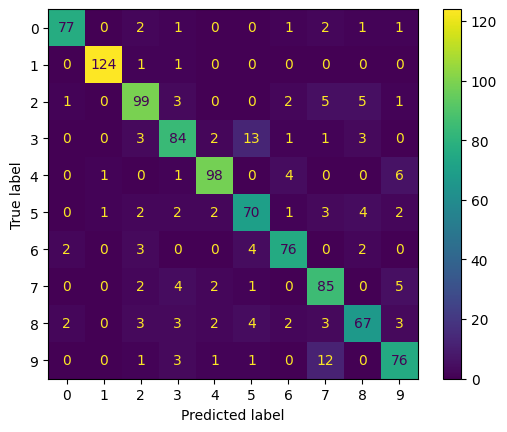

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = network.predict_with_conv(img_test[:1000])
actual = y_test[:1000]


cm = confusion_matrix(actual, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Zadanie 3
Pooling

In [12]:
network2 = neural_network(784)

network2.add_conv_layer(16, (3,3), -0.01, 0.01, network.relu, True)
network2.add_layer(10,-0.1,0.1)

np.set_printoptions(threshold=np.inf)
network2.update_with_conv_and_pool(img_train[:100],labal_train[:100],alpha=0.01,epochs=50)



Epoch nr 675    Total Error = 36.00208280981651
Epoch nr 675    Total Error = 35.97925692943775
Epoch nr 675    Total Error = 35.72817116336704
Epoch nr 675    Total Error = 35.1645835355599
Epoch nr 675    Total Error = 34.26078325621987
Epoch nr 675    Total Error = 32.92417265251871
Epoch nr 675    Total Error = 30.931923232037278
Epoch nr 675    Total Error = 28.160768602345097
Epoch nr 675    Total Error = 24.708899559653688
Epoch nr 675    Total Error = 21.074650212735524
Epoch nr 675    Total Error = 17.720117072751222
Epoch nr 675    Total Error = 14.895056203443387
Epoch nr 675    Total Error = 12.591561334626576
Epoch nr 675    Total Error = 10.73048008672051
Epoch nr 675    Total Error = 9.222502154655823
Epoch nr 675    Total Error = 7.981096970610325
Epoch nr 675    Total Error = 6.936952566672504
Epoch nr 675    Total Error = 6.040492682472554
Epoch nr 675    Total Error = 5.265138311680656
Epoch nr 675    Total Error = 4.599524240509488
Epoch nr 675    Total Error = 4.03

In [16]:
def evaluate_model2(network, test_inputs, test_outputs):
    predictions = network.predict_with_conv_and_pool(test_inputs)

    
    accuracy = np.mean(predictions == test_outputs) * 100
    return accuracy


accuracy = evaluate_model2(network2, img_test[:100], y_test[:100])
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 75.00%


Dla 10000 próbek treningowych i 10000 testowych: 86.67%

In [14]:
predictions = network2.predict_with_conv_and_pool(img_test[:1000])
actual = y_test[:1000]

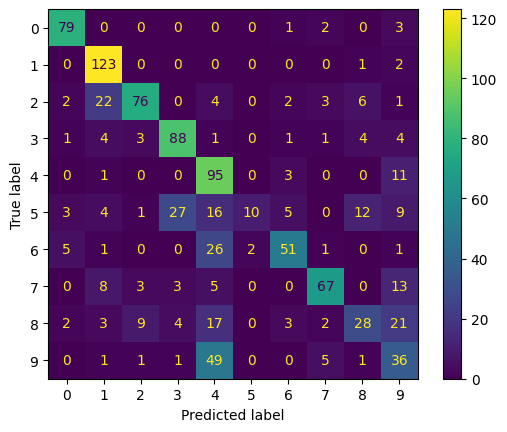

In [15]:
cm = confusion_matrix(actual, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()